# Part 2: Clustering Classification and Sentiment Analysis

## **Classification and Clustering**

Clustering methods compute a similarity (or closeness) measure, such as Euclidean distance, in order to decide whether two documents are ‘similar’ or not.  

Use the entire class corpus and do sentiment analysis for the positive and negative reviews.

Topic modeling is another way to group ‘similar’ documents into ‘clusters’.

# **1. Modules and Loading Data Set via Google Drive**

In [1]:
%%bash
# Cell 1 – one-time install (takes a few minutes)

pip install -q numpy==1.26.4 scipy==1.12.0 gensim==4.3.0
pip install -q --no-deps bertopic==0.17.0
pip install -q umap-learn hdbscan sentence-transformers tqdm \
               plotly scikit-learn pandas
# Optional CPU-only torch:
# pip install -q torch==2.6.0+cpu --index-url https://download.pytorch.org/whl/cpu


In [ ]:
# Cell 2 – force Colab to restart the *kernel* itself
import os, signal, sys
os.kill(os.getpid(), signal.SIGTERM)
# Session will "creash" here

In [1]:
# Cell 3: Verify installation and import all libraries
# After the automatic restart, this will be the first cell to run

# In Google Colab, select Runtime > Run cell and below
import numpy as np, gensim
from bertopic import BERTopic
print("NumPy :", np.__version__)     # 1.26.4
print("Gensim:", gensim.__version__) # 4.3.0
print("BERTopic imported OK")

NumPy : 1.26.4
Gensim: 4.3.0
BERTopic imported OK


In [2]:
import pandas as pd
import os
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import random
from dataclasses import dataclass

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer

import gensim
from gensim import corpora, similarities
from gensim.models import Word2Vec, LdaMulticore, TfidfModel, CoherenceModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import LsiModel,LdaModel

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE, MDS
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.naive_bayes import MultinomialNB

import scipy.cluster.hierarchy

from IPython.display import display, HTML

from typing import List, Callable, Dict

from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [3]:
# Cell 2: Verify installation and import all libraries
# After the automatic restart, this will be the first cell to run

# In Google Colab, select Runtime > Run cell and below
import numpy as np
print(f"NumPy version: {np.__version__}")

import gensim
print(f"Gensim version: {gensim.__version__}")

NumPy version: 1.26.4
Gensim version: 4.3.0


### Mount Google Drive to Colab Environment

<div class="alert alert-block alert-success">
    <b>Directories Required for Research Assignment</b>:<br>
1. Data Directory - Source Class Corpus Data<br>
2. Output Directory - Vocabulary<br>
</div>

#### Uncomment To Map Google Drive

In [4]:
#from google.colab import drive
#drive.mount('/content/gdrive')

&nbsp;

# **2. NLTK Downloads, etc, Data Wrangling Utility Functions, and Loading the Corpus**

In [5]:
# Only run this once, they will be downloaded.
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('punkt_tab',quiet=True)
nltk.download('omw-1.4',quiet=True)

True

<div class="alert alert-block alert-danger">
<b>Gensim</b> is a Python library for topic modelling, document indexing and similarity retrieval with large corpora. Target audience is the natural language processing (NLP) and information retrieval (IR) community <br><br>
    <b>https://pypi.org/project/gensim/ </b>
</div>

In [6]:
print("Genism Version: ", gensim.__version__)

Genism Version:  4.3.0


<div class="alert alert-block alert-info">
    <b>Suppress warning messages</b></div>

In [15]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## Data Wrangling Utility Functions

In [168]:
# COMMENTED OUT FUNCTIONS HERE NOT REFERENCED BY OTHER PARTS OF NOTEBOOK

def add_movie_descriptor(data: pd.DataFrame, corpus_df: pd.DataFrame):
    """
    Adds "Movie Description" to the supplied dataframe, in the form {Genre}_{P|N}_{Movie Title}_{DocID}
    """
    review = np.where(corpus_df['Review Type (pos or neg)'] == 'Positive', 'P', 'N')
    data['Descriptor'] = corpus_df['Genre of Movie'] + '_' + corpus_df['Movie Title'] + '_' + review + '_' + corpus_df['Doc_ID'].astype(str)

def get_corpus_df(path):
    data = pd.read_csv(path, encoding="utf-8")
    add_movie_descriptor(data, data)
    sorted_data = data.sort_values(['Descriptor'])
    indexed_data = sorted_data.set_index(['Doc_ID'])
    indexed_data['Doc_ID'] = indexed_data.index
    return indexed_data

@dataclass
class Document:
    doc_id: str
    text: str

# def normalize_document(document: Document) -> Document:
#     text = document.text
#     text = remove_punctuation(text)
#     text = lower_case(text)
#     text = remove_tags(text)
#     text = remove_special_chars_and_digits(text)

#     return Document(document.doc_id, text)

# def normalize_documents(documents: List[Document]) -> List[Document]:
#     """
#     Normalizes text for all given documents.
#     Removes punctuation, converts to lower case, removes tags and special characters.
#     """
#     return [normalize_document(x) for x in documents]

@dataclass
class TokenizedDocument:
    doc_id: str
    tokens: List[str]

# def tokenize_document(document: Document) -> TokenizedDocument:
#     tokens = nltk.word_tokenize(document.text)
#     return TokenizedDocument(document.doc_id, tokens)

# def tokenize_documents(documents: List[Document]) -> List[TokenizedDocument]:
#     return [tokenize_document(x) for x in documents]

# def lemmatize(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
#     result = []
#     lemmatizer = WordNetLemmatizer()
#     for document in documents:
#         output_tokens = [lemmatizer.lemmatize(w) for w in document.tokens]
#         result.append(TokenizedDocument(document.doc_id, output_tokens))
#
#     return result

# def stem(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
#     result = []
#     stemmer = PorterStemmer()
#     for document in documents:
#         output_tokens = [stemmer.stem(w) for w in document.tokens]
#         result.append(TokenizedDocument(document.doc_id, output_tokens))
#
#     return result

# def remove_stop_words(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
#     result = []
#
#     stop_words = set(nltk.corpus.stopwords.words('english'))
#     for document in documents:
#         filtered_tokens = [w for w in document.tokens if not w in stop_words]
#         result.append(TokenizedDocument(document.doc_id, filtered_tokens))
#
#     return result

# def add_flags(data: pd.DataFrame, casino_royale_doc_ids: List[int], action_doc_ids: List[int]):
#     data['is_casino_royale'] = data.index.isin(casino_royale_doc_ids)
#     data['is_action'] = data.index.isin(action_doc_ids)

# def get_all_tokens(documents: List[TokenizedDocument]) -> List[str]:
#     tokens = {y for x in documents for y in x.tokens}
#     return sorted(list(tokens))

def clean_doc(doc):
    #split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]
    #lowercase all words
    tokens = [word.lower() for word in tokens]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if w not in stop_words]
    # word lemmatizing
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

# def final_processed_text_disabled(doc):
#     #this is a function to join the processed text back
#     ' '.join(doc)
#     return doc

def tfidf(corpus, titles, ngram_range = (1,1)):
    #this is a function to created the tfidf matrix
    Tfidf=TfidfVectorizer(ngram_range=(1,1))

    #fit the vectorizer using final processed documents.  The vectorizer requires the
    #stiched back together document.

    TFIDF_matrix=Tfidf.fit_transform(corpus)

    #creating datafram from TFIDF Matrix

    # https://stackoverflow.com/questions/70215049/attributeerror-tfidfvectorizer-object-has-no-attribute-get-feature-names-out
    #words = Tfidf.get_feature_names() # For sklearn <= 0.24.x
    #matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names(), index=titles)

    words = Tfidf.get_feature_names_out() # For sklearn >= 1.0.x
    matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names_out(), index=titles)
    return matrix #,words

def One_Hot(variable):
    #this is a function to one hot encode the classes
    LE=LabelEncoder()
    LE.fit(variable)
    Label1=LE.transform(variable)
    OHE=OneHotEncoder()
    labels=OHE.fit_transform(Label1.reshape(-1,1)).toarray()
    return labels

&nbsp;

# **3. Functions Latent Semantic Analysis, Latent Dirichlet Allocation, Word2Vec Matrix**
1. Latent Semantic Analysis
2. Latent Dirichlet Allocation
3. Word2Vec Matrix creation

In [169]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):

    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LSA model
    # train model
    lsamodel = LsiModel(doc_term_matrix
                        ,num_topics=number_of_topics
                        ,id2word = dictionary
                        ,power_iters=100)
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    index = similarities.MatrixSimilarity(lsamodel[doc_term_matrix])

    return lsamodel,dictionary,index

def lsa(tfidf_matrix, terms, n_components = 10):
    #this is a function to execute lsa.  inputs to the function include the tfidf matrix and
    #the desired number of components.

    LSA = TruncatedSVD(n_components=10)
    LSA.fit(tfidf_matrix)

    for i, comp in enumerate(LSA.components_):
        terms_comp = zip(terms, comp)
        sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
        print("Topic "+str(i)+": ")
        for t in sorted_terms:
            print(t[0])

def create_gensim_lda_model(doc_clean,number_of_topics,words):

    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    ldamodel = LdaModel(doc_term_matrix
                        ,num_topics=number_of_topics
                        ,id2word = dictionary
                        ,alpha='auto'
                        ,eta='auto'
                        ,iterations=100
                        ,random_state=23
                        ,passes=20)
    # train model
    print(ldamodel.print_topics(num_topics=number_of_topics, num_words=words))
    index = similarities.MatrixSimilarity(ldamodel[doc_term_matrix])
    return ldamodel,dictionary,index,doc_term_matrix

def lda(tfidf_matrix, terms, topics = 3, num_words = 10):
    #this is a function to perform lda on the tfidf matrix.  function varibales include:
    #tfidf matrix, desired number of topic, and number of words per topic.

    topics = 3
    num_words = 10
    lda = LatentDirichletAllocation(n_components=topics).fit(tfidf_matrix)

    topic_dict = {}
    for topic_num, topic in enumerate(lda.components_):
        topic_dict[topic_num] = " ".join([terms[i]for i in topic.argsort()[:-num_words - 1:-1]])

    print(topic_dict)

def word2vec(processed_text, size = 100):
    #This is a function to generate the word2vec matrix. Input parameters include the
    #tokenized text and matrix size

    #word to vec
    model_w2v = Word2Vec(processed_text, vector_size=100, window=5, min_count=1, workers=4)

    #join all processed DSI words into single list
    processed_text_w2v=[]
    for i in processed_text:
        for k in i:
            processed_text_w2v.append(k)

    #obtian all the unique words from DSI
    w2v_words=list(set(processed_text_w2v))

    #can also use the get_feature_names() from TFIDF to get the list of words
    #w2v_words=Tfidf.get_feature_names()

    #empty dictionary to store words with vectors
    w2v_vectors={}

    #for loop to obtain weights for each word
    for i in w2v_words:
        temp_vec=model_w2v.wv[i]
        w2v_vectors[i]=temp_vec

    #create a final dataframe to view word vectors
    w2v_df=pd.DataFrame(w2v_vectors).transpose()
    print(w2v_df)
    return w2v_df

## This code below is Experimental#1 and Barry wants your feedback if this works or not

In [170]:
# Experimental#1 code here will show you the movie titles for the topics
# Uncomment all the code in this cell and it will override the above functions
# Also switch ot the modified Experiment#1 code lines elsewhere to add the "titles" parameter
# or you can ignore the commented lines for Experiment#1 code and continue your assignment.

# def create_gensim_lda_model(doc_clean,number_of_topics,words, titles):

#     dictionary = corpora.Dictionary(doc_clean)
#     doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
#     ldamodel = LdaModel(doc_term_matrix ,num_topics=number_of_topics,id2word = dictionary,alpha='auto',
#                                           eta='auto',iterations=100,random_state=23,passes=20)
#     print(ldamodel.print_topics(num_topics=number_of_topics, num_words=words))
#     index = similarities.MatrixSimilarity(ldamodel[doc_term_matrix])

#     # THIS CODE BELOW IS EXPERIMENTAL#1 AND BARRY WANTS YOUR FEEDBACK IF THIS WORKS OR NOT

#     # Method 1: Shows top 5 titles related to a topic; adjust the number accordingly.
#     for topic in ldamodel.print_topics(num_topics=number_of_topics, num_words=words):
#         topic_number = topic[0]
#         sims = index[ldamodel[doc_term_matrix[topic_number]]]
#         most_similar_titles = [titles[i[0]] for i in sorted(enumerate(sims), key=lambda item: -item[1])[:5]]
#         print('Most similar titles for topic #{}: {}'.format(topic_number, most_similar_titles))

#     # Method 2: Shows all titles sorted on most similar for each topic.
#     # Note you get all titles for all topics!

#     for document in doc_clean:
#         doc_bow = dictionary.doc2bow(document)
#         sims = index[ldamodel[doc_bow]]
#         most_similar_topic = sorted(enumerate(sims), key=lambda item: -item[1])[0][0]
#         #VERBOSE DEBUGGING: print('Document belongs to topic #{}'.format(most_similar_topic))

#     topic_titles = {}
#     for topic_number, topic in enumerate(ldamodel.print_topics(num_topics=number_of_topics, num_words=words)):
#         sims = index[ldamodel[doc_term_matrix[topic_number]]]
#         titles_for_topic = [titles[i[0]] for i in sorted(enumerate(sims), key=lambda item: -item[1])]
#         topic_titles[topic_number] = titles_for_topic
#         print('Titles for topic #{}: {}'.format(topic_number, titles_for_topic))

#     return ldamodel,dictionary,index,doc_term_matrix

# ##########

# def create_gensim_lsa_model(doc_clean, number_of_topics, words, titles):

#     dictionary = corpora.Dictionary(doc_clean)
#     doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

#     # generate LSA model
#     lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word=dictionary, power_iters=100)

#     print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
#     index = similarities.MatrixSimilarity(lsamodel[doc_term_matrix])

#     # THIS CODE BELOW IS EXPERIMENTAL AND BARRY WANTS YOUR FEEDBACK IF THIS WORKS OR NOT

#     # Method 1: Shows top 5 titles related to a topic; adjust the number accordingly.
#     for topic in lsamodel.print_topics(num_topics=number_of_topics, num_words=words):
#         topic_number = topic[0]
#         sims = index[lsamodel[doc_term_matrix[topic_number]]]
#         most_similar_titles = [titles[i[0]] for i in sorted(enumerate(sims), key=lambda item: -item[1])[:5]]
#         print('Most similar titles for topic #{}: {}'.format(topic_number, most_similar_titles))

#     # Method 2: Shows all titles sorted on most similar for each topic.
#     # Note you get all titles for all topics!

#     for document in doc_clean:
#         doc_bow = dictionary.doc2bow(document)
#         sims = index[lsamodel[doc_bow]]
#         most_similar_topic = sorted(enumerate(sims), key=lambda item: -item[1])[0][0]
#         #VERBOSE DEBUGGING: print('Document belongs to topic #{}'.format(most_similar_topic))

#     topic_titles = {}
#     for topic_number, topic in enumerate(lsamodel.print_topics(num_topics=number_of_topics, num_words=words)):
#         sims = index[lsamodel[doc_term_matrix[topic_number]]]
#         titles_for_topic = [titles[i[0]] for i in sorted(enumerate(sims), key=lambda item: -item[1])]
#         topic_titles[topic_number] = titles_for_topic
#         print('Titles for topic #{}: {}'.format(topic_number, titles_for_topic))

#     return lsamodel, dictionary, index

###########
#
# When you call create_gensim_lda_model(...) later on, you have to add titles to the call. Eg:
#
# model2,dictionary2,index2,doctermmatrix2=create_gensim_lda_model(processed_text,number_of_topics,words,titles)
#
# Similarly for LSA...

# **4. Modeling Functions: KMeans, SVM, Logistic, Naive Bayes, Randomforest, BERTopic**

In [171]:
def k_means(titles, tfidf_matrix, k=3):

    #this is a function to generate the k-means output using the tfidf matrix.  Inputs
    #to the function include: titles of text, processed text, and desired k value.
    #Returns dataframe indicating cluster number per document

    km = KMeans(n_clusters=k, random_state =89)
    km.fit(tfidf_matrix)
    clusters = km.labels_.tolist()

    Dictionary={'Doc Name':titles, 'Cluster':clusters,  'Text': final_processed_text}
    frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])
    #dictionary to store clusters and respective titles
    cluster_title={}

    #note doc2vec clusters will not have individual words due to the vector representation
    #is based on the entire document not indvidual words. As a result, there won't be individual
    #word outputs from each cluster.
    for i in range(k):
        temp=frame[frame['Cluster']==i]
        temp_title_list=[]
        for title in temp['Doc Name']:
            temp_title_list.append(title)
        cluster_title[i]=temp_title_list

    # How to see the results of the k-means clustering
    #print ("cluster_title", cluster_title)
    #print ("clusters", clusters)
    #print ("frame", frame)
    return cluster_title,clusters,frame

def bert_pretrained(texts):
    # Initialize the classifier
    classifier = pipeline("sentiment-analysis")

    # Perform sentiment analysis
    results = []
    for text in texts:
        # Since the classifier can only handle a certain amount of text,
        # you might need to truncate or split the text accordingly.
        result = classifier(text[:512])  # Adjust if necessary
        results.append(result)

    return results

def evaluate_model(y_test, y_pred, model_name="Model"):
    print(f"Evaluation Results for {model_name}:")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

def classifiers(x, y, model_type, cv = 3):

    #this function is to fit 3 different model scenarios.  Support vector machines, logistic regressions, naive bayes.
    #svm = Support vector machin
    #logistic = Logistic regression
    #naive_bayes = Naive Bayes Multinomial

    #can define cv value for cross validation.

    #function returns the train test split scores of each model.

    if model_type == 'svm':
        print("svm")
        model = SVC()

    elif model_type == 'logistic':
        print("logistic")
        model = LogisticRegression()

    elif model_type == 'naive_bayes':
        print("naive_bayes")
        model = MultinomialNB()

    elif model_type == 'randomforest':
        print("randomforest")
        model = RandomForestClassifier()

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=23)
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)
    accy = accuracy_score(y_test, predictions)
    evaluate_model(y_test, predictions, model_name=model_type)
    print(f"{model_type} Accuracy: {accy}")

## Visualization Utility Functions

In [172]:
def plot_lsa(number_of_topics, words):

    # BARRYC experimental#1
    #model,dictionary,index=create_gensim_lsa_model(processed_text,number_of_topics,words,titles)
    model,dictionary,index=create_gensim_lsa_model(processed_text,number_of_topics,words)

    for doc in processed_text:
        vec_bow = dictionary.doc2bow(doc)
        vec_lsi = model[vec_bow]  # convert the query to LSI space
        sims = index[vec_lsi] # perform a similarity query against the corpus

    fig, ax = plt.subplots(figsize=(30, 10))
    cax = ax.matshow(index, interpolation='nearest')
    ax.grid(True)
    plt.xticks(range(len(processed_text)), titles, rotation=90);
    plt.yticks(range(len(processed_text)), titles);
    fig.colorbar(cax)
    plt.show()
    return model

def plot_tfidf_matrix(cluster_title,clusters,TFIDF_matrix):
    # convert two components as we're plotting points in a two-dimensional plane
    # "precomputed" because we provide a distance matrix
    # we will also specify `random_state` so the plot is reproducible.

    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
    dist = 1 - cosine_similarity(TFIDF_matrix)
    pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
    xs, ys = pos[:, 0], pos[:, 1]


    #set up colors per clusters using a dict.  number of colors must correspond to K
    cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown', 4: 'firebrick',
                      5:'red', 6:'darksalmon', 7:'sienna'}

    #set up cluster names using a dict.
    cluster_dict=cluster_title

    #create data frame that has the result of the MDS plus the cluster numbers and titles
    df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters))))

    #group by cluster
    groups = df.groupby('label')

    fig, ax = plt.subplots(figsize=(20,20)) # set size
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    #iterate through groups to layer the plot
    #note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
    for name, group in groups:

        r = random.random()
        b = random.random()
        g = random.random()
        color = (r, g, b)

        ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
                label=cluster_dict[name], color=color,
                mec='none')
        ax.set_aspect('auto')
        ax.tick_params(\
            axis= 'x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelbottom='on')
        ax.tick_params(\
            axis= 'y',         # changes apply to the y-axis
            which='both',      # both major and minor ticks are affected
            left='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelleft='on')

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 30})      #show legend with only 1 point

## Loading the Class Corpus

In [173]:
CORPUS_PATH=\
'https://raw.githubusercontent.com/barrycforever/MSDS_453_NLP/main/MSDS453_ClassCorpus/MSDS453_ClassCorpus_Final_Sec56_v1_20250412.csv'
data = get_corpus_df(CORPUS_PATH)

In [174]:
#adding two columns to the dataframe to store the processed text and tokenized text
data['processed_text'] = data['Text'].apply(lambda x: clean_doc(x))

#creating final processed text variables for matrix creation
final_processed_text = [' '.join(x) for x in data['processed_text'].tolist()]
titles = data['DSI_Title'].tolist()
processed_text = data['processed_text'].tolist()

1. Dataframe = corpus_df
2. List = documents (Document ID, Text)

&nbsp;

# **5. Exploratory Data Analysis**

In [175]:
CORPUS_PATH=\
'https://raw.githubusercontent.com/barrycforever/MSDS_453_NLP/main/MSDS453_ClassCorpus/MSDS453_ClassCorpus_Final_Sec56_v1_20250412.csv'
corpus_df = get_corpus_df(CORPUS_PATH)
documents = [Document(x, y) for x, y in zip(corpus_df.Doc_ID, corpus_df.Text)]

In [176]:
corpus_df.shape

(230, 9)

In [177]:
corpus_df.head().T

Doc_ID                                                                  226  \
DSI_Title                                         RPX_Doc6_Angel_Has_Fallen   
Submission File Name                              RPX_Doc6_Angel_Has_Fallen   
Student Name                                                            RPX   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                                Angel_Has_Fallen   
Text                      Target is on the move." Heavily outnumbered an...   
Descriptor                                    Action_Angel_Has_Fallen_N_226   
Doc_ID                                                                  226   

Doc_ID                                                                  227  \
DSI_Title                                         RPX_Doc7_Angel_Has_Fallen   
Submission File Name                              RPX_Doc7_Angel_Has_Fallen   
Student Name                                                            RPX   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                                Angel_Has_Fallen   
Text                      The only question lingering in your mind while...   
Descriptor                                    Action_Angel_Has_Fallen_N_227   
Doc_ID                                                                  227   

Doc_ID                                                                  228  \
DSI_Title                                         RPX_Doc8_Angel_Has_Fallen   
Submission File Name                              RPX_Doc8_Angel_Has_Fallen   
Student Name                                                            RPX   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                                Angel_Has_Fallen   
Text                      The sleepy, dopey action bonanza "Angel Has Fa...   
Descriptor                                    Action_Angel_Has_Fallen_N_228   
Doc_ID                                                                  228   

Doc_ID                                                                  229  \
DSI_Title                                         RPX_Doc9_Angel_Has_Fallen   
Submission File Name                              RPX_Doc9_Angel_Has_Fallen   
Student Name                                                            RPX   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                                Angel_Has_Fallen   
Text                      I don't know what I was hoping to get from Ang...   
Descriptor                                    Action_Angel_Has_Fallen_N_229   
Doc_ID                                                                  229   

Doc_ID                                                                  230  
DSI_Title                                        RPX_Doc10_Angel_Has_Fallen  
Submission File Name                             RPX_Doc10_Angel_Has_Fallen  
Student Name                                                            RPX  
Genre of Movie                                                       Action  
Review Type (pos or neg)                                           Negative  
Movie Title                                                Angel_Has_Fallen  
Text                      Ric Roman Waugh's Angel Has Fallen sees U.S. S...  
Descriptor                                    Action_Angel_Has_Fallen_N_230  
Doc_ID                                                                  230

In [178]:
print(corpus_df.info());

<class 'pandas.core.frame.DataFrame'>
Index: 230 entries, 226 to 295
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   DSI_Title                 230 non-null    object
 1   Submission File Name      230 non-null    object
 2   Student Name              230 non-null    object
 3   Genre of Movie            230 non-null    object
 4   Review Type (pos or neg)  230 non-null    object
 5   Movie Title               230 non-null    object
 6   Text                      230 non-null    object
 7   Descriptor                230 non-null    object
 8   Doc_ID                    230 non-null    int64 
dtypes: int64(1), object(8)
memory usage: 18.0+ KB
None


In [179]:
print(corpus_df['Movie Title'].unique())

['Angel_Has_Fallen' 'Inception' 'No_Time_to_Die' 'Sudden_Impact' 'Taken'
 'Taxi' 'Barbie' "Don't_Look_Up" 'Holmes_and_Watson' 'Lost_city'
 'Mean_Girls' 'Red_Notice' 'Drag_me_to_hell' 'It_Chapter_Two' 'Lamb'
 'Orphan' 'TheOthers' 'The_conjuring_2' 'Batman' 'Equilibrium'
 'Minority_Report' 'Oblivion' 'Pitch_Black']


Exploring different numbers of...


> LSA: **2**, **6**, **20** concepts and **10** words<br>
> LDA: **2**, **6**, **20** topics and **10** words<br>

1.   *Model Complexity*
2.   *Model Interpretability*
3.   *Evaluation of Coherence*
4.   *Avoid Overfitting*
5.   *Practical Implications*
6.   *Computational Implications*


## Latent Semantic Analysis - Research Number of Topics and Number of Words

### Plotting 2 concepts and 10 words

[(0, '0.450*"movie" + 0.228*"character" + 0.151*"film" + 0.149*"story" + 0.145*"first" + 0.128*"scene" + 0.116*"thing" + 0.114*"would" + 0.112*"action" + 0.109*"world"'), (1, '0.777*"barbie" + 0.182*"barbies" + 0.152*"world" + 0.142*"gerwig" + 0.125*"robbie" + -0.123*"harry" + -0.116*"movie" + 0.113*"gosling" + 0.103*"stereotypical" + 0.098*"barbieland"')]


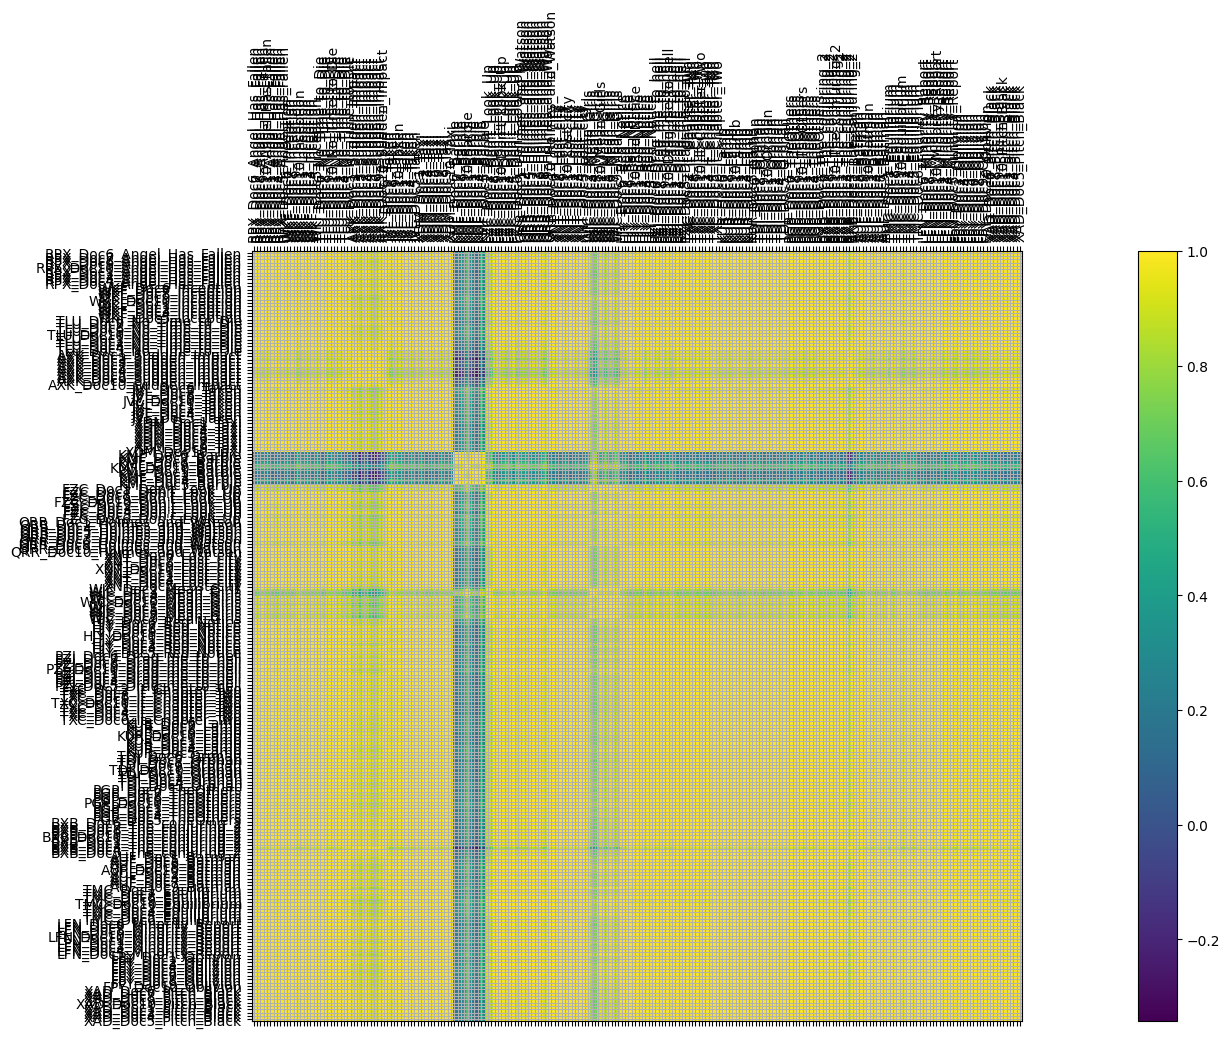

In [180]:
model_2concepts_10words=plot_lsa(2, 10)

### Plotting 6 concepts and 10 words

[(0, '0.450*"movie" + 0.228*"character" + 0.151*"film" + 0.149*"story" + 0.145*"first" + 0.128*"scene" + 0.116*"thing" + 0.114*"would" + 0.112*"action" + 0.109*"world"'), (1, '0.777*"barbie" + 0.182*"barbies" + 0.152*"world" + 0.142*"gerwig" + 0.125*"robbie" + -0.123*"harry" + -0.116*"movie" + 0.113*"gosling" + 0.103*"stereotypical" + 0.098*"barbieland"'), (2, '-0.562*"harry" + -0.284*"dirty" + -0.251*"eastwood" + 0.219*"house" + 0.181*"child" + -0.158*"impact" + -0.154*"sudden" + -0.131*"locke" + -0.122*"barbie" + 0.121*"grace"'), (3, '-0.524*"movie" + 0.260*"harry" + 0.212*"house" + 0.176*"child" + 0.153*"film" + 0.140*"grace" + 0.134*"horror" + 0.133*"dirty" + -0.119*"notice" + 0.108*"eastwood"'), (4, '-0.279*"house" + 0.271*"character" + -0.260*"movie" + 0.214*"bruce" + 0.206*"batman" + -0.166*"child" + 0.143*"planet" + -0.137*"harry" + 0.136*"action" + 0.129*"joker"'), (5, '0.405*"bruce" + 0.396*"batman" + 0.250*"joker" + 0.234*"wayne" + 0.163*"burton" + 0.139*"gotham" + -0.130*"p

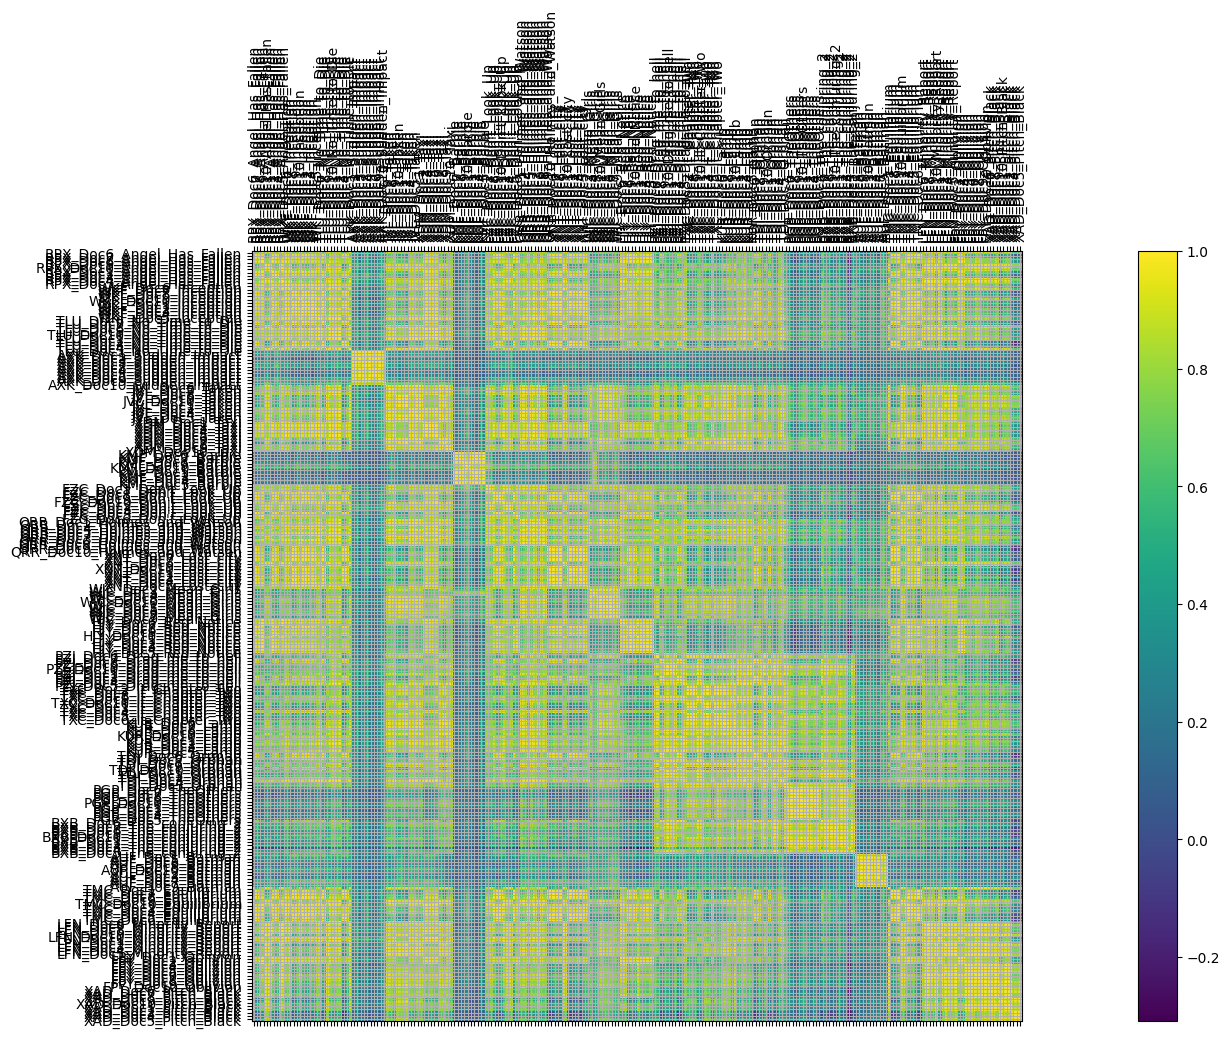

In [181]:
model_6concepts_10words=plot_lsa(6, 10)

### Plotting 20 concepts and 10 words

[(0, '0.450*"movie" + 0.228*"character" + 0.151*"film" + 0.149*"story" + 0.145*"first" + 0.128*"scene" + 0.116*"thing" + 0.114*"would" + 0.112*"action" + 0.109*"world"'), (1, '-0.777*"barbie" + -0.182*"barbies" + -0.152*"world" + -0.142*"gerwig" + -0.125*"robbie" + 0.123*"harry" + 0.116*"movie" + -0.113*"gosling" + -0.103*"stereotypical" + -0.098*"barbieland"'), (2, '-0.562*"harry" + -0.284*"dirty" + -0.251*"eastwood" + 0.219*"house" + 0.181*"child" + -0.158*"impact" + -0.154*"sudden" + -0.131*"locke" + -0.122*"barbie" + 0.121*"grace"'), (3, '0.524*"movie" + -0.260*"harry" + -0.212*"house" + -0.176*"child" + -0.153*"film" + -0.140*"grace" + -0.134*"horror" + -0.133*"dirty" + 0.119*"notice" + -0.108*"eastwood"'), (4, '-0.279*"house" + 0.271*"character" + -0.260*"movie" + 0.214*"bruce" + 0.206*"batman" + -0.166*"child" + 0.143*"planet" + -0.137*"harry" + 0.136*"action" + 0.129*"joker"'), (5, '0.405*"bruce" + 0.396*"batman" + 0.250*"joker" + 0.234*"wayne" + 0.163*"burton" + 0.139*"gotham"

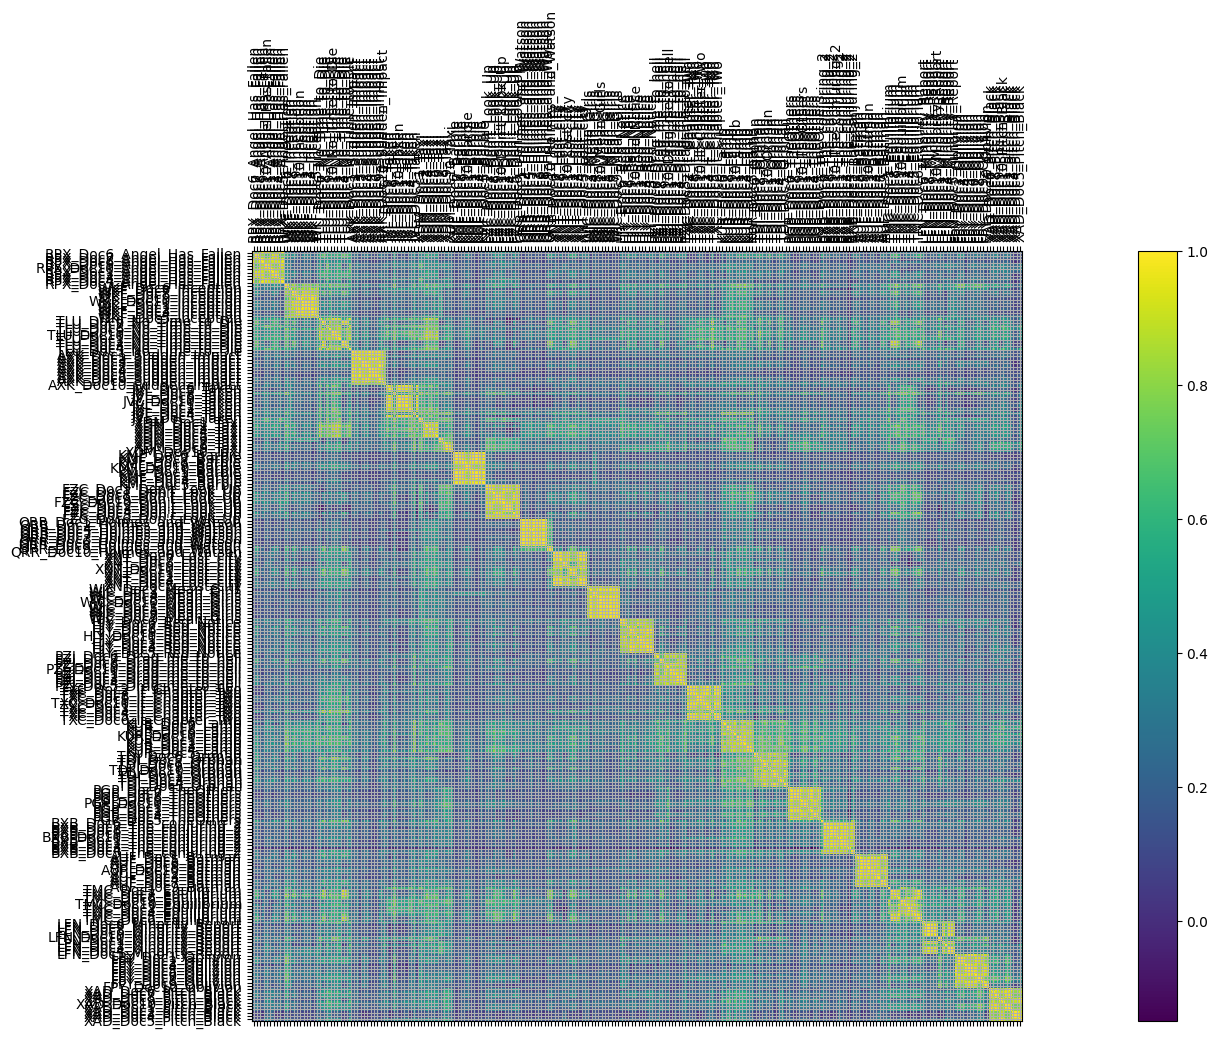

In [182]:
model_20concepts_10words=plot_lsa(20, 10)

### Compare LSA Model Coherence

In [183]:
topics = [6, 2, 10]
coherence_values = []
for t in topics:
    #BARRYC EXPERIMENTAL#1
    #lsamodel,dictionary,index = create_gensim_lsa_model(processed_text,t,10, titles)
    lsamodel,dictionary,index = create_gensim_lsa_model(processed_text,t,10)


    coherence_model_lsa = CoherenceModel(model=lsamodel, dictionary=dictionary, texts=processed_text, coherence='c_v')
    coherence_lsa = coherence_model_lsa.get_coherence()
    coherence_values.append(coherence_lsa)


coherence ={'6 concepts 10 words':coherence_values[0],
           '2 concepts 10 words': coherence_values[1],
           '20 concepts 10 words':coherence_values[2]}

print(coherence)

[(0, '0.450*"movie" + 0.228*"character" + 0.151*"film" + 0.149*"story" + 0.145*"first" + 0.128*"scene" + 0.116*"thing" + 0.114*"would" + 0.112*"action" + 0.109*"world"'), (1, '0.777*"barbie" + 0.182*"barbies" + 0.152*"world" + 0.142*"gerwig" + 0.125*"robbie" + -0.123*"harry" + -0.116*"movie" + 0.113*"gosling" + 0.103*"stereotypical" + 0.098*"barbieland"'), (2, '-0.562*"harry" + -0.284*"dirty" + -0.251*"eastwood" + 0.219*"house" + 0.181*"child" + -0.158*"impact" + -0.154*"sudden" + -0.131*"locke" + -0.122*"barbie" + 0.121*"grace"'), (3, '-0.524*"movie" + 0.260*"harry" + 0.212*"house" + 0.176*"child" + 0.153*"film" + 0.140*"grace" + 0.134*"horror" + 0.133*"dirty" + -0.119*"notice" + 0.108*"eastwood"'), (4, '-0.279*"house" + 0.271*"character" + -0.260*"movie" + 0.214*"bruce" + 0.206*"batman" + -0.166*"child" + 0.143*"planet" + -0.137*"harry" + 0.136*"action" + 0.129*"joker"'), (5, '0.405*"bruce" + 0.396*"batman" + 0.250*"joker" + 0.234*"wayne" + 0.163*"burton" + 0.139*"gotham" + -0.130*"p

[(0, '0.450*"movie" + 0.228*"character" + 0.151*"film" + 0.149*"story" + 0.145*"first" + 0.128*"scene" + 0.116*"thing" + 0.114*"would" + 0.112*"action" + 0.109*"world"'), (1, '-0.777*"barbie" + -0.182*"barbies" + -0.152*"world" + -0.142*"gerwig" + -0.125*"robbie" + 0.123*"harry" + 0.116*"movie" + -0.113*"gosling" + -0.103*"stereotypical" + -0.098*"barbieland"')]


[(0, '0.450*"movie" + 0.228*"character" + 0.151*"film" + 0.149*"story" + 0.145*"first" + 0.128*"scene" + 0.116*"thing" + 0.114*"would" + 0.112*"action" + 0.109*"world"'), (1, '0.777*"barbie" + 0.182*"barbies" + 0.152*"world" + 0.142*"gerwig" + 0.125*"robbie" + -0.123*"harry" + -0.116*"movie" + 0.113*"gosling" + 0.103*"stereotypical" + 0.098*"barbieland"'), (2, '-0.562*"harry" + -0.284*"dirty" + -0.251*"eastwood" + 0.219*"house" + 0.181*"child" + -0.158*"impact" + -0.154*"sudden" + -0.131*"locke" + -0.122*"barbie" + 0.121*"grace"'), (3, '0.524*"movie" + -0.260*"harry" + -0.212*"house" + -0.176*"child" + -0.153*"film" + -0.140*"grace" + -0.134*"horror" + -0.133*"dirty" + 0.119*"notice" + -0.108*"eastwood"'), (4, '0.279*"house" + -0.271*"character" + 0.260*"movie" + -0.214*"bruce" + -0.206*"batman" + 0.166*"child" + -0.143*"planet" + 0.137*"harry" + -0.136*"action" + -0.129*"joker"'), (5, '-0.405*"bruce" + -0.396*"batman" + -0.250*"joker" + -0.234*"wayne" + -0.163*"burton" + -0.139*"gotha

## Latent Dirichlet Allocation - Research Number of Topics and Number of Words

In [184]:
######################################
#EXPERIMENT WITH THESE PARAMETERS
number_of_topics=4
words=20
#####################################

[(0, '0.006*"movie" + 0.003*"holmes" + 0.003*"world" + 0.003*"year" + 0.002*"mckay" + 0.002*"character" + 0.002*"would" + 0.002*"story" + 0.002*"bruce" + 0.002*"harry" + 0.002*"watson" + 0.002*"almost" + 0.002*"doesnt" + 0.002*"comedy" + 0.002*"ferrell" + 0.002*"something" + 0.002*"dream" + 0.002*"never" + 0.002*"reilly" + 0.002*"film"'), (1, '0.009*"movie" + 0.006*"character" + 0.004*"film" + 0.004*"harry" + 0.003*"thing" + 0.003*"scene" + 0.003*"first" + 0.003*"story" + 0.002*"bryan" + 0.002*"eastwood" + 0.002*"audience" + 0.002*"loretta" + 0.002*"tatum" + 0.002*"bullock" + 0.002*"daughter" + 0.002*"doesnt" + 0.002*"really" + 0.002*"would" + 0.002*"thats" + 0.002*"every"'), (2, '0.009*"movie" + 0.004*"character" + 0.004*"first" + 0.004*"film" + 0.004*"story" + 0.004*"house" + 0.003*"child" + 0.003*"world" + 0.003*"scene" + 0.002*"still" + 0.002*"year" + 0.002*"director" + 0.002*"james" + 0.002*"horror" + 0.002*"never" + 0.002*"girl" + 0.002*"oblivion" + 0.002*"would" + 0.002*"thing" 

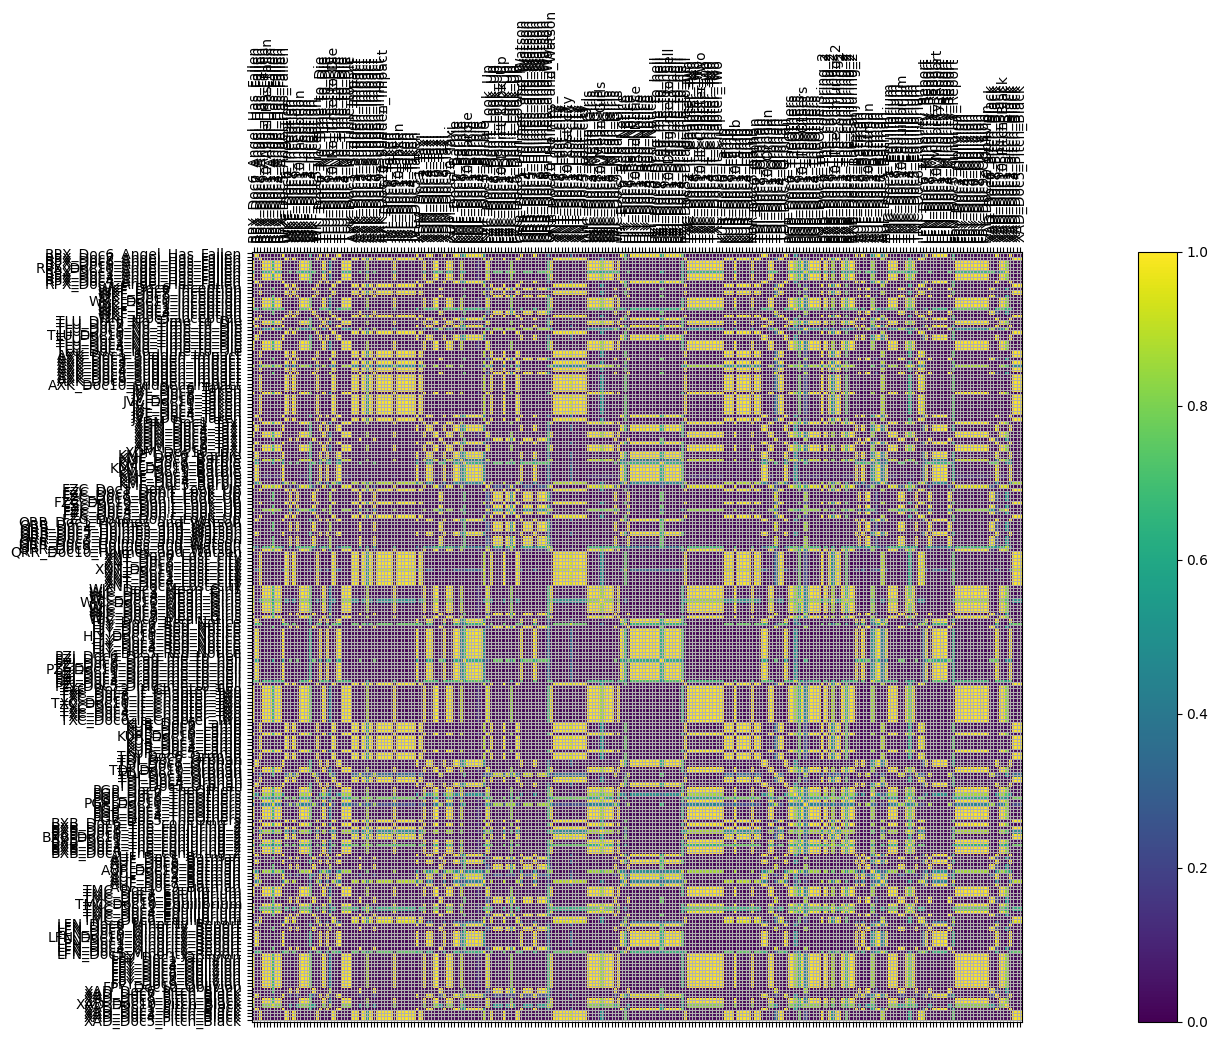

In [185]:
# BARRYC EXPERIMENTAL#1
#model2,dictionary2,index2,doctermmatrix2=create_gensim_lda_model(processed_text,number_of_topics,words,titles)
model2,dictionary2,index2,doctermmatrix2=create_gensim_lda_model(processed_text,number_of_topics,words)

for doc in processed_text:
    vec_bow2 = dictionary2.doc2bow(doc)
    vec2 = model2[vec_bow2]  # convert the query to embedded space
    sims2 = index2[vec2]  # perform a similarity query against the corpus
    #print(list(enumerate(sims2)))

fig, ax = plt.subplots(figsize=(30, 10))
cax = ax.matshow(index2, interpolation='nearest')
ax.grid(True)
plt.xticks(range(len(processed_text)), titles, rotation=90);
plt.yticks(range(len(processed_text)), titles);
fig.colorbar(cax)
plt.show()

### Compare LDA Model Coherence

In [186]:
topics = [6, 2, 10]
coherence_values = []
for t in topics:
    #BARRYC EXPERIMENTAL#1
    #ldamodel,dictionary,index, matrix = create_gensim_lda_model(processed_text,t,10,titles)
    ldamodel,dictionary,index, matrix = create_gensim_lda_model(processed_text,t,10)


    coherence_model_lda = CoherenceModel(model=ldamodel, dictionary=dictionary, texts=processed_text, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)


coherence ={'6 topic 10 words':coherence_values[0],
           '2 topic 10 words': coherence_values[1],
           '20 topic 10 words':coherence_values[2]}

print(coherence)

[(0, '0.006*"movie" + 0.005*"bruce" + 0.004*"holmes" + 0.003*"world" + 0.003*"would" + 0.003*"batman" + 0.003*"watson" + 0.003*"comedy" + 0.003*"mckay" + 0.003*"year"'), (1, '0.009*"movie" + 0.005*"character" + 0.004*"loretta" + 0.003*"bullock" + 0.003*"tatum" + 0.003*"film" + 0.003*"thing" + 0.003*"audience" + 0.002*"every" + 0.002*"scene"'), (2, '0.008*"movie" + 0.005*"house" + 0.005*"first" + 0.005*"child" + 0.004*"character" + 0.003*"film" + 0.003*"story" + 0.003*"year" + 0.003*"horror" + 0.003*"girl"'), (3, '0.007*"movie" + 0.006*"notice" + 0.004*"character" + 0.004*"action" + 0.004*"johnson" + 0.004*"christine" + 0.004*"raimi" + 0.003*"batman" + 0.003*"reynolds" + 0.003*"first"'), (4, '0.009*"movie" + 0.007*"barbie" + 0.005*"story" + 0.004*"character" + 0.004*"scene" + 0.003*"action" + 0.003*"really" + 0.003*"film" + 0.003*"world" + 0.002*"dream"'), (5, '0.008*"harry" + 0.007*"movie" + 0.006*"character" + 0.004*"eastwood" + 0.004*"dirty" + 0.004*"film" + 0.003*"first" + 0.003*"sc

[(0, '0.006*"movie" + 0.003*"character" + 0.002*"first" + 0.002*"world" + 0.002*"film" + 0.002*"action" + 0.002*"story" + 0.002*"batman" + 0.002*"year" + 0.002*"holmes"'), (1, '0.009*"movie" + 0.005*"character" + 0.004*"film" + 0.003*"thing" + 0.003*"story" + 0.003*"first" + 0.003*"scene" + 0.003*"barbie" + 0.003*"child" + 0.003*"house"')]


[(0, '0.008*"holmes" + 0.006*"movie" + 0.006*"mckay" + 0.005*"watson" + 0.004*"ferrell" + 0.004*"reilly" + 0.004*"world" + 0.004*"comedy" + 0.003*"would" + 0.003*"comet"'), (1, '0.011*"movie" + 0.006*"character" + 0.004*"loretta" + 0.004*"film" + 0.004*"emotion" + 0.003*"theyre" + 0.003*"tatum" + 0.003*"bullock" + 0.003*"planet" + 0.003*"thing"'), (2, '0.007*"movie" + 0.005*"first" + 0.005*"house" + 0.005*"character" + 0.004*"child" + 0.004*"horror" + 0.004*"film" + 0.003*"scene" + 0.003*"loser" + 0.003*"chapter"'), (3, '0.005*"action" + 0.004*"booth" + 0.004*"house" + 0.004*"reynolds" + 0.004*"johnson" + 0.003*"black" + 0.003*"first" + 0.003*"hartley" + 0.003*"notice" + 0.003*"movie"'), (4, '0.009*"movie" + 0.004*"story" + 0.004*"really" + 0.004*"future" + 0.004*"anderton" + 0.003*"action" + 0.003*"scene" + 0.003*"cruise" + 0.003*"film" + 0.003*"precrime"'), (5, '0.015*"harry" + 0.008*"eastwood" + 0.007*"dirty" + 0.007*"character" + 0.006*"movie" + 0.005*"film" + 0.004*"sudden" + 0.00

# **BERTopic**

This section of the code demonstrates the BERTopic library to extract topics and visualize the distribution and relationships between them.

You've already done preprocessing earlier by cleaning the text by removing punctuation, filtering out stop words and short tokens, and converting text to lowercase. You could also try with the raw sentences too!

Then there is topic modeling with BERTopic to identify and analyze underlying themes in the dataset.

&nbsp;

In [187]:
import re,string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt

import pandas as pd
import os
import numpy as np
from bertopic import BERTopic
import warnings
warnings.filterwarnings('ignore')

In [188]:
# ALREADY DONE EARLIER

# import nltk
# nltk.download('stopwords')

#functions used to process text and create the required TFIDF and Doc2vec Matrices
# def clean_doc(doc):
#     ...

# def final_processed_text(doc):
#     #this is a function to join the processed text back
#     ...

In [189]:
# ALREADY DONE EARLIER

# #read in class corpus csv into python
# data=pd.read_csv(r'MSDS453_QA_20220906.csv')

# #adding two columns to the dataframe to store the processed text and tokenized text
# data['processed_text'] = data['Text'].apply(lambda x: clean_doc(x))

# #creating final processed text variables for matrix creation
# final_processed_text = [' '.join(x) for x in data['processed_text'].tolist()]
# titles = data['Movie Title'].tolist()
# processed_text = data['processed_text'].tolist()

In [190]:
len(final_processed_text)

230

In [191]:
final_processed_text[1]

'question lingering watching angel fallen would simply franchise third instalment show stopping every subsequent significantly worse quality three sucksville angel keeping track third olympus london fallen shoe modern mclaine banning gerard butler president terror attack throw something banning framed entire secret service think want potus brought thriller reminded quickly fugitive moment third exactly moment finale movie intended homage quite mediocre point movie thrill surprise everything stale wonder managed travel couple decade focus pacing element earned revelation ingenuity delivering suspense modicum constructed action thrill whole thing meathead movie drone show something hour however designed particular audience love pulpy actioners president danger front welloiled machine morgan freeman play potus believably compassionate butler flexing biceps jumping lake going render boner audience stuff butler investigation treated predictably overdramatic manner culminates ridiculous mant

In [192]:
from bertopic import BERTopic
topic_model = BERTopic(min_topic_size=2)

In [193]:
topics, probs = topic_model.fit_transform(final_processed_text)

In [194]:
topic_model.get_topic_info()

Topic  Count                                     Name  \
0      -1     14              -1_movie_comedy_girl_future   
1       0     11          0_notice_johnson_reynolds_gadot   
2       1     11     1_emotion_preston_equilibrium_cleric   
3       2     10               2_batman_bruce_wayne_joker   
4       3     10          3_johannsson_maria_sheep_ingvar   
5       4     10          4_barbie_barbies_gerwig_gosling   
6       5     10          5_esther_orphan_child_sarsgaard   
7       6     10               6_house_grace_child_others   
8       7     10            7_christine_raimi_gypsy_curse   
9       8     10             8_harry_eastwood_dirty_locke   
10      9     10              9_craig_craigs_james_casino   
11     10     10          10_dream_inception_nolans_nolan   
12     11     10         11_loser_chapter_pennywise_derry   
13     12      9          12_oblivion_cruise_earth_harper   
14     13      9  13_warren_lorraine_conjuring_amityville   
15     14      9           14_planet_riddick_diesel_pitch   
16     15      9          15_holmes_watson_ferrell_reilly   
17     16      7           16_bryan_neeson_daughter_taken   
18     17      7     17_anderton_minority_precrime_report   
19     18      6        18_loretta_tatum_bullock_treasure   
20     19      6           19_fallen_banning_angel_butler   
21     20      6             20_mckay_comet_medium_satire   
22     21      5            21_girl_regina_school_musical   
23     22      4           22_panahi_tehran_jafar_iranian   
24     23      3      23_banning_president_service_secret   
25     24      3             24_regina_girl_musical_janis   
26     25      3          25_comet_president_mckay_orlean   
27     26      3       26_fallon_latifah_washburn_comedic   
28     27      3      27_creature_twohys_riddick_decision   
29     28      2        28_tatum_bullock_lorettas_loretta   

                                       Representation  \
0   [movie, comedy, girl, future, quite, american,...   
1   [notice, johnson, reynolds, gadot, hartley, th...   
2   [emotion, preston, equilibrium, cleric, offend...   
3   [batman, bruce, wayne, joker, burton, gotham, ...   
4   [johannsson, maria, sheep, ingvar, rapace, cou...   
5   [barbie, barbies, gerwig, gosling, robbie, bar...   
6   [esther, orphan, child, sarsgaard, fuhrman, li...   
7   [house, grace, child, others, servant, amenaba...   
8   [christine, raimi, gypsy, curse, woman, wendy,...   
9   [harry, eastwood, dirty, locke, sudden, clint,...   
10  [craig, craigs, james, casino, daniel, movie, ...   
11  [dream, inception, nolans, nolan, subconscious...   
12  [loser, chapter, pennywise, derry, adult, musc...   
13  [oblivion, cruise, earth, harper, alien, victo...   
14  [warren, lorraine, conjuring, amityville, jane...   
15  [planet, riddick, diesel, pitch, survivor, bla...   
16  [holmes, watson, ferrell, reilly, brother, she...   
17  [bryan, neeson, daughter, taken, paris, kidnap...   
18  [anderton, minority, precrime, report, spielbe...   
19  [loretta, tatum, bullock, treasure, radcliffe,...   
20  [fallen, banning, angel, butler, president, tr...   
21  [mckay, comet, medium, satire, world, climate,...   
22  [girl, regina, school, musical, original, broa...   
23  [panahi, tehran, jafar, iranian, making, camer...   
24  [banning, president, service, secret, fallen, ...   
25  [regina, girl, musical, janis, song, instead, ...   
26  [comet, president, mckay, orlean, political, l...   
27  [fallon, latifah, washburn, comedic, belle, qu...   
28  [creature, twohys, riddick, decision, characte...   
29  [tatum, bullock, lorettas, loretta, movie, cha...   

                                  Representative_Docs  
0   [doesnt convince comedy comedy truly comfort m...  
1   [entirely writerdirector rawson marshall thurb...  
2   [movie centuryhey thats centuryat third world ...  
3   [year burton entrance pantheon batman film adm...  
4   [moment nothing happens icelandic enigma come ...  
5   [bar

In [195]:
topic_model.visualize_barchart()

In [196]:
topic_model.visualize_heatmap()

In [197]:
topic_model.get_document_info(final_processed_text)

Document  Topic  \
0    target heavily outnumbered outgunned banning g...     23   
1    question lingering watching angel fallen would...     19   
2    sleepy dopey action bonanza angel fallen disap...     19   
3    hoping angel fallen latest entry inexplicably ...     19   
4    roman waugh angel fallen secret service agent ...     19   
..                                                 ...    ...   
225  passenger spaceship rogue asteroid comet force...     14   
226  packed razzledazzle special effect fueled aggr...     14   
227  pitch black directed david twohy released stan...     14   
228  directed david twohy released stand remarkable...     14   
229  distinguishes pitch black scifi contemporary a...     27   

                                    Name  \
0    23_banning_president_service_secret   
1         19_fallen_banning_angel_butler   
2         19_fallen_banning_angel_butler   
3         19_fallen_banning_angel_butler   
4         19_fallen_banning_angel_butler   
..                                   ...   
225       14_planet_riddick_diesel_pitch   
226       14_planet_riddick_diesel_pitch   
227       14_planet_riddick_diesel_pitch   
228       14_planet_riddick_diesel_pitch   
229  27_creature_twohys_riddick_decision   

                                        Representation  \
0    [banning, president, service, secret, fallen, ...   
1    [fallen, banning, angel, butler, president, tr...   
2    [fallen, banning, angel, butler, president, tr...   
3    [fallen, banning, angel, butler, president, tr...   
4    [fallen, banning, angel, butler, president, tr...   
..                                                 ...   
225  [planet, riddick, diesel, pitch, survivor, bla...   
226  [planet, riddick, diesel, pitch, survivor, bla...   
227  [planet, riddick, diesel, pitch, survivor, bla...   
228  [planet, riddick, diesel, pitch, survivor, bla...   
229  [creature, twohys, riddick, decision, characte...   

                                   Representative_Docs  \
0    [gerard butler praise acting credit perseveran...   
1    [sleepy dopey action bonanza angel fallen disa...   
2    [sleepy dopey action bonanza angel fallen disa...   
3    [sleepy dopey action bonanza angel fallen disa...   
4    [sleepy dopey action bonanza angel fallen disa...   
..                                                 ...   
225  [practitioner guilty pleasure bmoviessuch unde...   
226  [practitioner guilty pleasure bmoviessuch unde...   
227  [practitioner guilty pleasure bmoviessuch unde...   
228  [practitioner guilty pleasure bmoviessuch unde...   
229  [beneath veneer gritty realism pitch black fra...   

                                           Top_n_words  Probability  \
0    banning - president - service - secret - falle...     1.000000   
1    fallen - banning - angel - butler - president ...     0.862580   
2    fallen - banning - angel - butler - president ...     1.000000   
3    fallen - banning - angel - butler - president ...     0.809977   
4    fallen - banning - angel - butler - president ...     1.000000   
..                                                 ...          ...   
225  planet - riddick - diesel - pitch - survivor -...     1.000000   
226  planet - riddick - diesel - pitch - survivor -...     1.000000   
227  planet - riddick - diesel - pitch - survivor -...     1.000000   
228  planet - riddick - diesel - pitch - survivor -...     1.000000   
229  creature - twohys - riddick - decision - chara...     1.000000   

     Representative_document  
0                       True  
1                      False  
2                       True  
3                      False  
4                      False  
..                       ...  
225                    False  
226                    False  
227                     True  
228                     True  
229                     True  

[230 rows x 8 columns]

# **6. Cluster Model Research: KMeans, SVM, Logistic, Naive Bayes, Randomforest, BERT**


## NLP Supervised and Unsupervised Learning Methods:
1. K-Means Clustering (Unsupervised)
2. Support Vector Machines (SVMs) (Supervised)
3. (Multinomial) Naïve Bayes (MultinomialNB) (Supervised)
4. Logistic Regression (Supervised)

### Generate TF-IDF For Analysis

In [198]:
tfidf_matrix = tfidf(final_processed_text, titles, ngram_range = (1,1))

### Evaluate the Best k via Silhouette Score

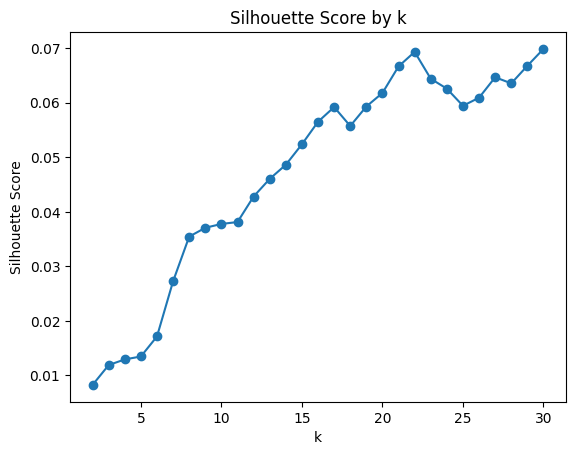

In [199]:
from sklearn.metrics import silhouette_score

def evaluate_k(tfidf_matrix, max_k=30):
    scores = []
    for k in range(2, max_k + 1):
        km = KMeans(n_clusters=k, random_state=42)
        km.fit(tfidf_matrix)
        score = silhouette_score(tfidf_matrix, km.labels_)
        scores.append((k, score))
    return scores

# plot to find the best k
import matplotlib.pyplot as plt

k_scores = evaluate_k(tfidf_matrix, max_k=30)
ks = [x[0] for x in k_scores]
scores = [x[1] for x in k_scores]

plt.plot(ks, scores, marker='o')
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score by k")
plt.show()

### KMeans Clustering

<div class="alert alert-block alert-success">
    <b>sklearn.cluster.KMeans</b>:<br>
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html<br><br>
<b>KMeans Default Parameters</b>:<br>
    class sklearn.cluster.KMeans(n_clusters=8, *, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto')
    </div>

In [200]:
cluster_title,clusters,k_means_df = k_means(titles, tfidf_matrix, k=23)

### Access Each Cluster - Changing Dictionary KeyValue from 0 to k

In [201]:
cluster_title[9]

['JVL_Doc6_Taken',
 'JVL_Doc7_Taken',
 'JVL_Doc8_Taken',
 'JVL_Doc9_Taken',
 'JVL_Doc10_Taken',
 'JVL_Doc1_Taken',
 'JVL_Doc2_Taken',
 'JVL_Doc3_Taken',
 'JVL_Doc5_Taken']

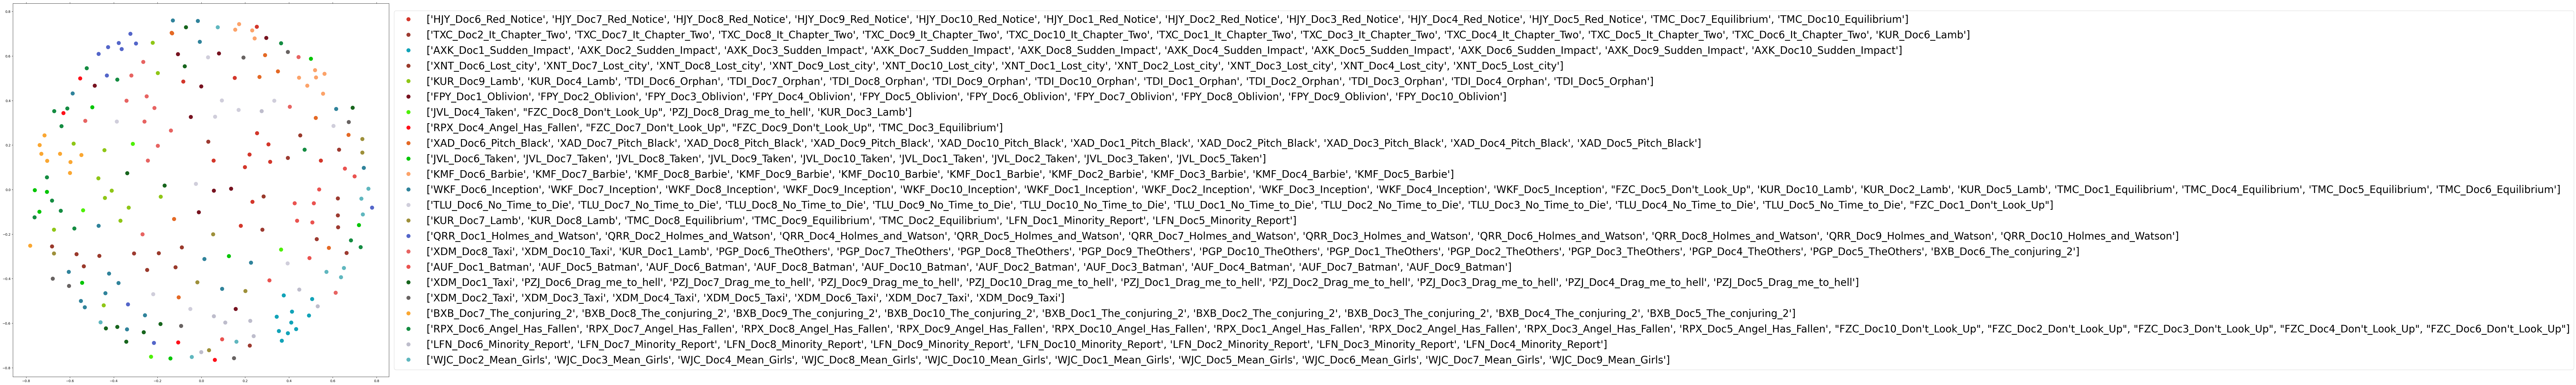

In [202]:
plot_tfidf_matrix(cluster_title,clusters,tfidf_matrix)

In [203]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

def print_cluster_top_words(frame, cluster_id, top_n=10):
    texts = frame[frame['Cluster'] == cluster_id]['Text']
    vectorizer = CountVectorizer(stop_words='english')
    X = vectorizer.fit_transform(texts)
    word_freq = X.toarray().sum(axis=0)
    vocab = vectorizer.get_feature_names_out()
    word_count = dict(zip(vocab, word_freq))
    top_words = Counter(word_count).most_common(top_n)
    print(f"Cluster {cluster_id} Top Words: {top_words}")

# Print the high-frequency words of the first few clusters
for i in range(5):
    print_cluster_top_words(k_means_df, i)

# Output the number of documents in each cluster
print(k_means_df['Cluster'].value_counts())

Cluster 0 Top Words: [('notice', 50), ('movie', 40), ('johnson', 31), ('reynolds', 26), ('gadot', 20), ('hartley', 20), ('thief', 19), ('action', 18), ('booth', 17), ('dwayne', 17)]
Cluster 1 Top Words: [('chapter', 31), ('loser', 30), ('pennywise', 25), ('character', 22), ('derry', 18), ('james', 16), ('adult', 15), ('child', 15), ('horror', 15), ('movie', 15)]
Cluster 2 Top Words: [('harry', 76), ('eastwood', 39), ('dirty', 37), ('movie', 21), ('locke', 20), ('impact', 19), ('sudden', 19), ('clint', 18), ('jennifer', 17), ('eastwoods', 13)]
Cluster 3 Top Words: [('movie', 38), ('loretta', 33), ('bullock', 32), ('tatum', 32), ('treasure', 19), ('channing', 16), ('character', 16), ('comedy', 16), ('radcliffe', 16), ('sandra', 16)]
Cluster 4 Top Words: [('esther', 44), ('movie', 33), ('child', 30), ('orphan', 28), ('character', 20), ('little', 17), ('husband', 13), ('sarsgaard', 13), ('scene', 13), ('thing', 13)]
Cluster
11    18
20    14
15    14
4     12
0     12
12    11
1     11
3  

### Generate Labels for Supervised Learning Models

In [204]:
labels = data['Review Type (pos or neg)'].apply(lambda x: 0 if x.lower().split(' ')[0] == 'negative' else 1)
print(labels)

Doc_ID
226    0
227    0
228    0
229    0
230    0
      ..
291    1
292    1
293    1
294    1
295    1
Name: Review Type (pos or neg), Length: 230, dtype: int64


### Support Vector Machines

<div class="alert alert-block alert-success">
    <b>Support vector machines (SVMs)</b>:<br>
https://scikit-learn.org/stable/modules/svm.html<br><br>
    Set of supervised learning methods used for classification, regression and outliers detection
    </div>

In [205]:
classifiers(tfidf_matrix, labels, 'svm')

svm
Evaluation Results for svm:
Confusion Matrix:
[[27  0]
 [42  0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.39      1.00      0.56        27
           1       0.00      0.00      0.00        42

    accuracy                           0.39        69
   macro avg       0.20      0.50      0.28        69
weighted avg       0.15      0.39      0.22        69

svm Accuracy: 0.391304347826087


### Logistic Regression Model

<div class="alert alert-block alert-success">
    <b>sklearn.linear_model.LogisticRegression</b>:<br>
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html<br><br>
<b>Logistic Regression Default Parameters</b>:<br>
    class sklearn.linear_model.LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
    </div>

In [206]:
classifiers(tfidf_matrix, labels, 'logistic')

logistic
Evaluation Results for logistic:
Confusion Matrix:
[[26  1]
 [41  1]]

Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.96      0.55        27
           1       0.50      0.02      0.05        42

    accuracy                           0.39        69
   macro avg       0.44      0.49      0.30        69
weighted avg       0.46      0.39      0.24        69

logistic Accuracy: 0.391304347826087


### Naive Bayes

<div class="alert alert-block alert-success">
    <b>Naive Bayes</b>:<br>
https://scikit-learn.org/stable/modules/naive_bayes.html<br><br>
    Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable.
    </div>

In [207]:
classifiers(tfidf_matrix, labels, 'naive_bayes')

naive_bayes
Evaluation Results for naive_bayes:
Confusion Matrix:
[[26  1]
 [41  1]]

Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.96      0.55        27
           1       0.50      0.02      0.05        42

    accuracy                           0.39        69
   macro avg       0.44      0.49      0.30        69
weighted avg       0.46      0.39      0.24        69

naive_bayes Accuracy: 0.391304347826087


### Random Forest

<div class="alert alert-block alert-success">
    <b>sklearn.ensemble.RandomForestClassifier</b>:<br>
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html<br><br>
<b>RandomForest Classifier Default Parameters</b>:<br>
    class sklearn.ensemble.RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
    </div>

In [208]:
classifiers(tfidf_matrix, labels, 'randomforest')

randomforest
Evaluation Results for randomforest:
Confusion Matrix:
[[25  2]
 [32 10]]

Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.93      0.60        27
           1       0.83      0.24      0.37        42

    accuracy                           0.51        69
   macro avg       0.64      0.58      0.48        69
weighted avg       0.68      0.51      0.46        69

randomforest Accuracy: 0.5072463768115942


### BERT Pre-Trained Binary Classification (Sentiment-Analysis)

We use the pre-trained DistilBERT model "sentiment-analysis" fine-tuned for sentiment analysis to categorize text sentiments into positive, negative, or neutral.

https://wellsr.com/python/hugging-face-pipelines-for-python-natural-language-processing/

In [209]:
def bert_classifier_binary(texts, labels):
    # Initialize the sentiment-analysis pipeline
    classifier = pipeline("sentiment-analysis")

    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.10, random_state=42)

    # Perform sentiment analysis
    results = classifier(X_test, truncation=True)

    # Map BERT's output to binary labels
    predictions = [0 if result['label'] == 'NEGATIVE' else 1 for result in results]

    # Calculate accuracy
    accuracy = accuracy_score(y_test, predictions)

    evaluate_model(y_test, predictions, model_name="BERT")

    print(f"Binary Classification Accuracy: {accuracy}")

In [210]:
# How about the raw text?
raw_text = [text.strip().lower() for text in data['Text']]

raw_text[:1]

['target is on the move." heavily outnumbered and outgunned, mike banning (gerard butler) strives to exit a multi-level, bullet-riddled structure as squadrons of soldiers descend upon his position. but thanks to his skills, he\'s perfectly capable of overcoming the incredible odds  or at least that\'s what the overwrought editing will have audiences assume. in this opening sequence alone, the camerawork is so shaky and hard to follow that it\'s impossible to know exactly what is going on. back in washington d.c., banning awaits an offer to become the director of the secret service for president allan trumbull (morgan freeman). but despite his many years on the job, working to protect the president from all sorts of mayhem, mike isn\'t certain he\'s ready to sit behind a desk for the rest of his career. his abuse of pills for migraines, dizziness, and insomnia doesn\'t help in making the decision, though his wife leah (piper perabo) and their infant daughter lynn would probably apprecia

In [211]:
import re

def clean_non_ascii(text):
    # Replace common non-ASCII characters with their ASCII equivalents
    text = text.replace('\x93', '"').replace('\x94', '"')  # Smart double quotes
    text = text.replace('\x91', "'").replace('\x92', "'")  # Smart single quotes
    text = text.replace('\x96', '-').replace('\x97', '-')  # Long dashes

    # Remove any remaining non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    return text

raw_text_cleaned = [clean_non_ascii(text) for text in raw_text]
raw_text_cleaned[:1]

['target is on the move." heavily outnumbered and outgunned, mike banning (gerard butler) strives to exit a multi-level, bullet-riddled structure as squadrons of soldiers descend upon his position. but thanks to his skills, he\'s perfectly capable of overcoming the incredible odds  or at least that\'s what the overwrought editing will have audiences assume. in this opening sequence alone, the camerawork is so shaky and hard to follow that it\'s impossible to know exactly what is going on. back in washington d.c., banning awaits an offer to become the director of the secret service for president allan trumbull (morgan freeman). but despite his many years on the job, working to protect the president from all sorts of mayhem, mike isn\'t certain he\'s ready to sit behind a desk for the rest of his career. his abuse of pills for migraines, dizziness, and insomnia doesn\'t help in making the decision, though his wife leah (piper perabo) and their infant daughter lynn would probably apprecia

In [212]:
# Compare raw text with final processed text:

data['final_processed_text'] = final_processed_text

data['raw_text'] = raw_text
# data['raw_text'] = raw_text_cleaned

comparison_df = pd.DataFrame({
    'Label': labels,
    'Processed_Text': data['final_processed_text'],
    'Raw_Text': data['raw_text']
})

print(comparison_df)


        Label                                     Processed_Text  \
Doc_ID                                                             
226         0  target heavily outnumbered outgunned banning g...   
227         0  question lingering watching angel fallen would...   
228         0  sleepy dopey action bonanza angel fallen disap...   
229         0  hoping angel fallen latest entry inexplicably ...   
230         0  roman waugh angel fallen secret service agent ...   
...       ...                                                ...   
291         1  passenger spaceship rogue asteroid comet force...   
292         1  packed razzledazzle special effect fueled aggr...   
293         1  pitch black directed david twohy released stan...   
294         1  directed david twohy released stand remarkable...   
295         1  distinguishes pitch black scifi contemporary a...   

                                                 Raw_Text  
Doc_ID                                                 

In [213]:
bert_classifier_binary(raw_text, labels)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


Evaluation Results for BERT:
Confusion Matrix:
[[ 6  1]
 [ 3 13]]

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.86      0.75         7
           1       0.93      0.81      0.87        16

    accuracy                           0.83        23
   macro avg       0.80      0.83      0.81        23
weighted avg       0.85      0.83      0.83        23

Binary Classification Accuracy: 0.8260869565217391


In [214]:
bert_classifier_binary(raw_text_cleaned, labels)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


Evaluation Results for BERT:
Confusion Matrix:
[[ 6  1]
 [ 3 13]]

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.86      0.75         7
           1       0.93      0.81      0.87        16

    accuracy                           0.83        23
   macro avg       0.80      0.83      0.81        23
weighted avg       0.85      0.83      0.83        23

Binary Classification Accuracy: 0.8260869565217391


In [215]:
bert_classifier_binary(final_processed_text, labels)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


Evaluation Results for BERT:
Confusion Matrix:
[[6 1]
 [9 7]]

Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.86      0.55         7
           1       0.88      0.44      0.58        16

    accuracy                           0.57        23
   macro avg       0.64      0.65      0.56        23
weighted avg       0.73      0.57      0.57        23

Binary Classification Accuracy: 0.5652173913043478


### BERT Pre-Trained Multiple Classification (Genre)

Our genre classification utilizes a BERT-based uncased model to distinguish text genres. This approach capitalizes on BERT's deep semantic understanding from uncased text, aiming for genre identification.

https://huggingface.co/google-bert/bert-base-uncased

#### Traditional Methods

In [216]:
genre_labels = data["Genre of Movie"]
encoder = LabelEncoder()
encoded_genres = encoder.fit_transform(genre_labels)

In [217]:
from sklearn.feature_extraction.text import TfidfVectorizer
# generate TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1,1))
tfidf_matrix = vectorizer.fit_transform(final_processed_text)

classifiers(tfidf_matrix, encoded_genres, 'logistic')
classifiers(tfidf_matrix, encoded_genres, 'svm')
classifiers(tfidf_matrix, encoded_genres, 'naive_bayes')
classifiers(tfidf_matrix, encoded_genres, 'randomforest')

logistic
Evaluation Results for logistic:
Confusion Matrix:
[[17  0  0  0]
 [ 0 23  0  0]
 [ 0  0 15  0]
 [ 0  0  0 14]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        23
           2       1.00      1.00      1.00        15
           3       1.00      1.00      1.00        14

    accuracy                           1.00        69
   macro avg       1.00      1.00      1.00        69
weighted avg       1.00      1.00      1.00        69

logistic Accuracy: 1.0
svm
Evaluation Results for svm:
Confusion Matrix:
[[17  0  0  0]
 [ 0 23  0  0]
 [ 0  0 15  0]
 [ 0  0  0 14]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        23
           2       1.00      1.00      1.00        15
           3       1.00      1.00      1.00  

#### Bert Classifier

In [218]:
def bert_classifier_multiple(texts, labels):
    # Encode labels
    encoder = LabelEncoder()
    encoded_labels = encoder.fit_transform(labels)

    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(texts, encoded_labels, test_size=0.10, random_state=42)

    # Load a tokenizer and model suited for your multi-class task
    #tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    #tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased")
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
    #model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(encoder.classes_))
    #model = AutoModelForSequenceClassification.from_pretrained("bert-large-uncased", num_labels=len(encoder.classes_))
    model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(encoder.classes_))

    # Initialize the pipeline
    classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

    # Perform classification
    results = classifier(X_test, truncation=True)

    # Decode predictions to original labels
    predictions = [int(result['label'].split('_')[-1]) for result in results]
    decoded_predictions = encoder.inverse_transform(predictions)

    # Calculate accuracy
    decoded_y_test = encoder.inverse_transform(y_test)
    accuracy = accuracy_score(decoded_y_test, decoded_predictions)
    print(f"Multi-class Classification Accuracy: {accuracy}")


In [219]:
bert_classifier_multiple(final_processed_text, data["Genre of Movie"])

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu


Multi-class Classification Accuracy: 0.08695652173913043


In [220]:
bert_classifier_multiple(raw_text, data["Genre of Movie"])

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu


Multi-class Classification Accuracy: 0.17391304347826086


In [221]:
bert_classifier_multiple(raw_text_cleaned, data["Genre of Movie"])

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu


Multi-class Classification Accuracy: 0.2608695652173913


### Confusion Matrix

This code snippet generates a confusion matrix to visually evaluate the performance of our classification model by comparing the actual versus predicted labels.

In [222]:
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

def bert_classifier_multiple(texts, labels):
    # Initialize and fit the label encoder
    encoder = LabelEncoder()
    encoded_labels = encoder.fit_transform(labels)

    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(texts, encoded_labels, test_size=0.10, random_state=42)

    # Load a tokenizer and model suited for the multi-class task
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    #tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased")

    model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(encoder.classes_))
    #model = AutoModelForSequenceClassification.from_pretrained("bert-large-uncased", num_labels=len(encoder.classes_))

    # Initialize the pipeline
    classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

    # Perform classification
    results = classifier(X_test, truncation=True)

    # Process predictions
    predictions = [int(result['label'].split('_')[-1]) for result in results]

    # Decode predictions and true labels back to original labels
    decoded_predictions = encoder.inverse_transform(predictions)
    decoded_y_test = encoder.inverse_transform(y_test)

    # Return the true labels, predicted labels, and the encoder (for plotting confusion matrix)
    return decoded_y_test, decoded_predictions, encoder

# Assuming `data["Genre of Movie"]` is your labels array
true_labels, predicted_labels, encoder = bert_classifier_multiple(final_processed_text, data["Genre of Movie"])


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu


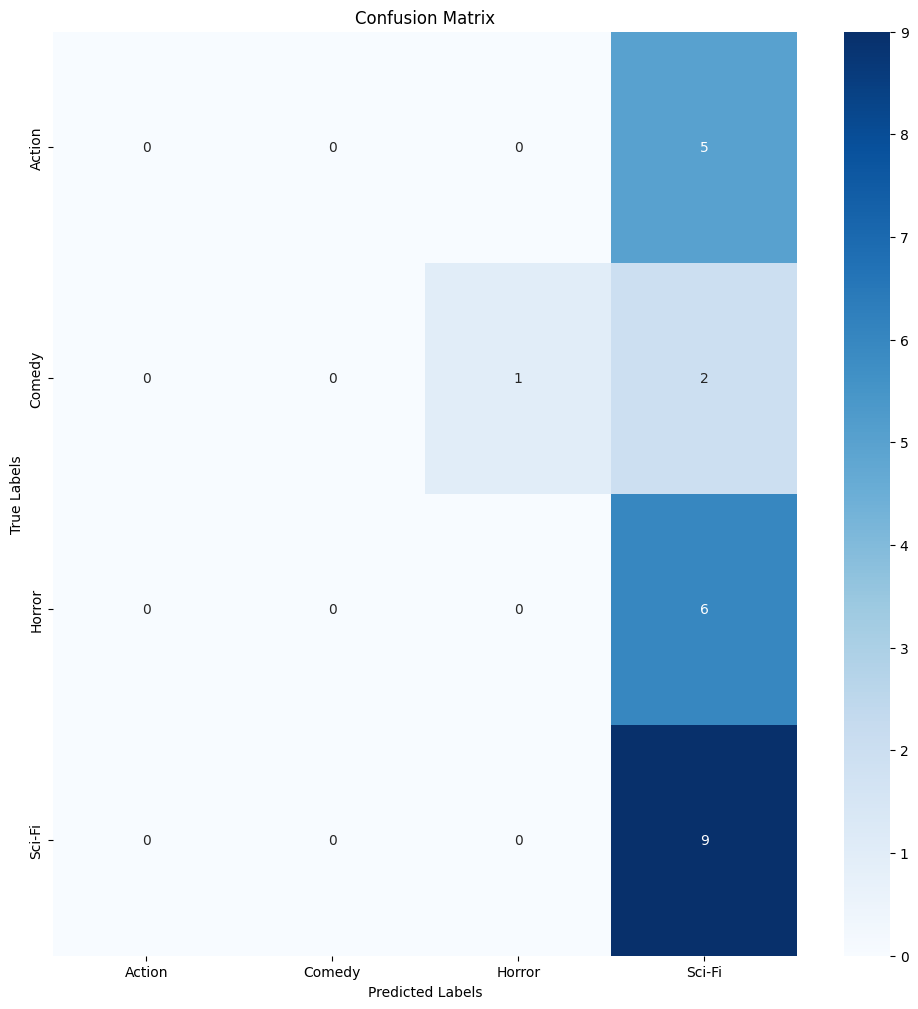

In [223]:
def plot_confusion_matrix(true_labels, predicted_labels, classes):
    cm = confusion_matrix(true_labels, predicted_labels, labels=classes)
    plt.figure(figsize=(12, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

plot_confusion_matrix(true_labels, predicted_labels, encoder.classes_)


In [224]:

from sklearn.metrics import confusion_matrix
import pandas as pd

def print_confusion_matrix(true_labels, predicted_labels, classes):
    # Generate the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=classes)

    # Create a DataFrame from the confusion matrix
    cm_df = pd.DataFrame(cm, index=classes, columns=classes)

    # Print the confusion matrix
    print("Confusion Matrix:")
    print(cm_df)

# Call the function with the true labels, predicted labels, and class names
print_confusion_matrix(true_labels, predicted_labels, encoder.classes_)


Confusion Matrix:
        Action  Comedy  Horror  Sci-Fi
Action       0       0       0       5
Comedy       0       0       1       2
Horror       0       0       0       6
Sci-Fi       0       0       0       9


In [225]:
# Add Classification Report
print(classification_report(true_labels, predicted_labels, target_names=encoder.classes_))

              precision    recall  f1-score   support

      Action       0.00      0.00      0.00         5
      Comedy       0.00      0.00      0.00         3
      Horror       0.00      0.00      0.00         6
      Sci-Fi       0.41      1.00      0.58         9

    accuracy                           0.39        23
   macro avg       0.10      0.25      0.15        23
weighted avg       0.16      0.39      0.23        23

